In [7]:
import os.path
import torch
from CGAN_PyTorch.cgan_pytorch.models.generator import GeneratorCIFAR
from gan_evaluation import plot_cgan_generated_images
from tqdm import tqdm
from gan_evaluation import load_classifier, generate_images, classifier_accuracy, calculate_emd, pca_images, \
    plot_pca
from torch.utils.data import DataLoader
from utils import get_dataset_custom_training


device = 'cuda:0'
noise=100

generator = GeneratorCIFAR(latent_dim=noise).to(device)

In [8]:
generator.load_state_dict(torch.load(os.path.join('..', 'weights', 'CGAN_20240531-115557.pth')))

<All keys matched successfully>

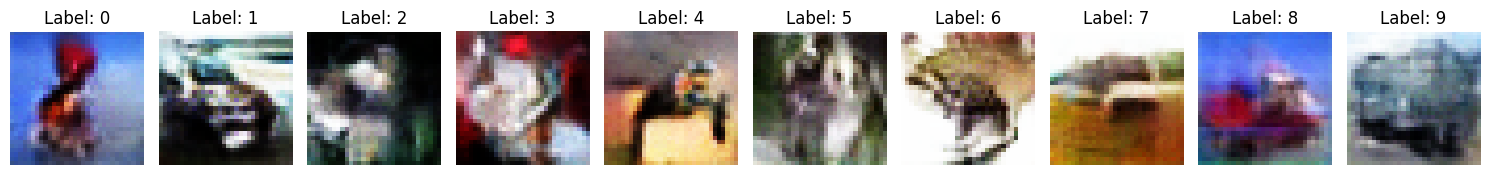

Files already downloaded and verified
Files already downloaded and verified


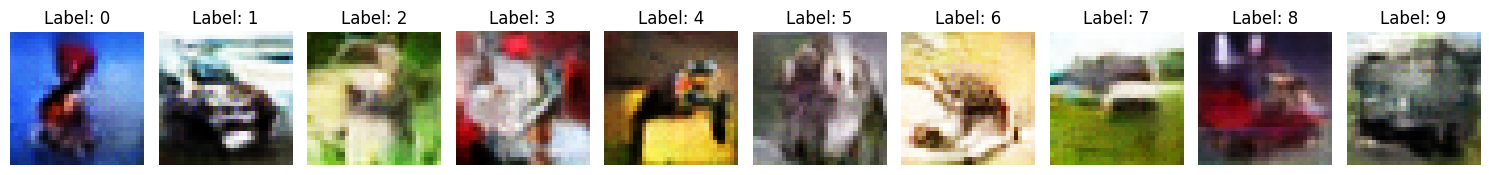

Testing: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]


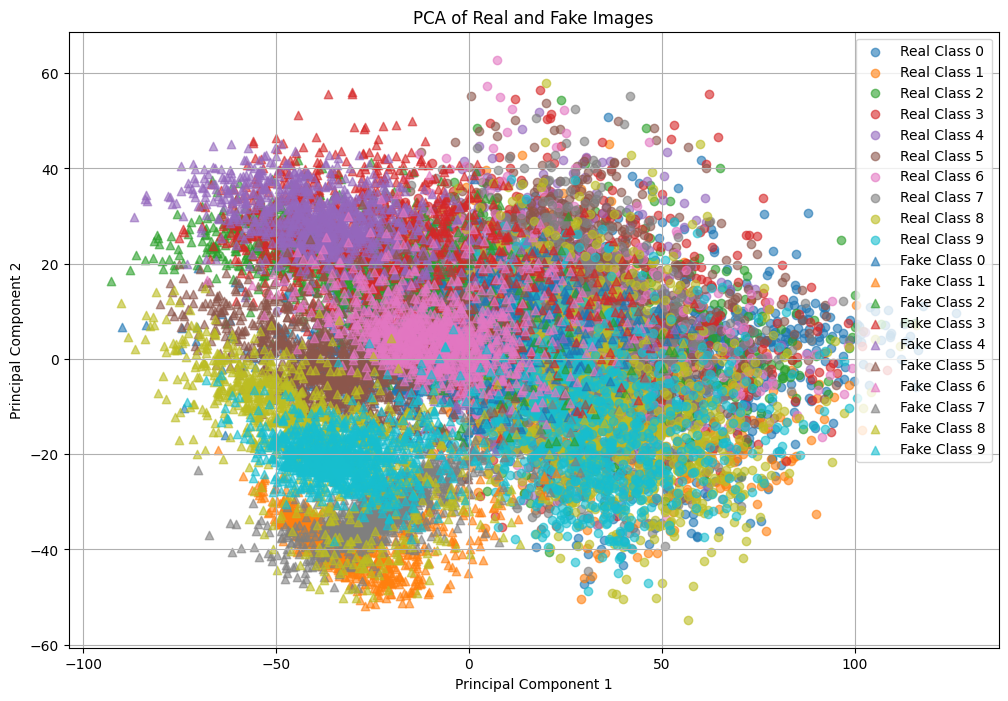

Earth Mover's Distance: 1.18892050539039
Real images accuracy: 0.85, Fake images accuracy: 0.2007


In [9]:
plot_cgan_generated_images(generator, device, 'cifar', num_classes=10,
                           latent_dim=noise)

_, test_dataset = get_dataset_custom_training('cifar')

testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

plot_cgan_generated_images(generator, device, 'cifar', num_classes=10,
                           latent_dim=noise)
real_preds = 0
fake_preds = 0
emd_real_images = torch.empty(0, ).to(device)
emd_fake_images = torch.empty(0, ).to(device)
labels_list = torch.empty(0, ).to(device)

model = load_classifier('cifar', model_path=os.path.join('..', 'weights', 'cifar_classifier.pth'))
for batch_idx, (images, labels) in enumerate(tqdm(testloader, f"Testing: ")):
    images = images.to(device)
    labels = labels.to(device)
    fake_images = generate_images(generator, device, labels, num_images=images.size(0), latent_dim=noise,
                                  dataset='cifar')
    emd_real_images = torch.cat((emd_real_images, images), dim=0)
    emd_fake_images = torch.cat((emd_fake_images, fake_images), dim=0)
    labels_list = torch.cat((labels_list, labels), dim=0)
    real_preds_temp, fake_preds_temp = classifier_accuracy(model, images, fake_images, labels, 'cifar',
                                                           device)
    real_preds += real_preds_temp
    fake_preds += fake_preds_temp

real_accuracy = real_preds / len(test_dataset)
fake_accuracy = fake_preds / len(test_dataset)

emd = calculate_emd(emd_real_images, emd_fake_images)
pca_real, pca_fake = pca_images(emd_real_images, emd_fake_images)
plot_pca(pca_real, pca_fake, labels_list)
print(f"Earth Mover's Distance: {emd}")
print(f"Real images accuracy: {real_accuracy}, Fake images accuracy: {fake_accuracy}")